In [1]:
!pip install -q catboost shap

In [2]:
import pandas as pd
from sklearn.metrics import accuracy_score
import sklearn.model_selection
import matplotlib.pyplot as plt
import statistics 
import catboost
import shap
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import KFold, cross_val_score
from scipy.stats import ttest_rel
import seaborn as sns
import scipy.stats as sps

ModuleNotFoundError: No module named 'seaborn'

In [22]:
data_gtm = pd.read_excel('/content/drive/MyDrive/2_down_2-3-4т:сут-регрессия.xlsx', sheet_name='больше_2')
# data_gtm = pd.read_excel('/content/drive/MyDrive/4_down.xlsx')
#data_gtm_20 = pd.read_excel('/content/drive/MyDrive/4_down_20_features.xlsx')
print(f'Размер исходной выборки data_gtm: {data_gtm.shape}')
display(data_gtm['Группа по эффективности'].value_counts())

Размер исходной выборки data_gtm: (59, 21)


0    39
1    20
Name: Группа по эффективности, dtype: int64

In [10]:
data_gtm.columns

Index(['Группа по эффективности', 'Qж_ф', '%воды_руч', 'ННО ', 'Vкс_факт, м3',
       'Уд. Vкс, м3/м', 'V_т.в., м3', 'Твыд, ч', 'Nнефт.пр., ед.',
       'h_нефтТР., ед.', 'Кпзп, мкм2', 'Кузп, мкм2', 'S', 'Рпл, МПа',
       'Рзаб, МПа', 'Рплтек/Рнач', 'Рплтек/Рнас', 'Рзабтек/Рнас',
       'Рзабтек/Рпл нач', 'Рзабтек/Рпл тек', 'N ГРП/КГРП'],
      dtype='object')

In [11]:
#rename any initial columns for better reading
data_gtm = data_gtm.rename(columns={'СЭ (1-УШГН; 2-УЭЦН)': 'СЭ', 
                                    'ОФ (0-нет;1-АСПО;2-Коррозия;3-другое)': 'ОФ',
                                    'Усл.тип технологии (1-без буфера; 2-с буфером)': 'Усл.тип технологии', 
                                    'Боковой ствол (1-осн.,2-БС)': 'Боковой ствол',
                                    'Дней с послед.КРС более 5 лет (0-нет; 1-да)': 'Дней с послед.КРС более 5 лет',
                                    'Менее 365 дней ДО (1 - да, 0 - нет)': 'Менее 365 дней ДО'
                                    })

In [23]:
#Категориальные признаки:
cat_features_20 = ['N ГРП/КГРП']

Так как начальных данных очень мало, не будем использовать валидационную выборку. 

Проверим модель с помощью кросс-валидации, для того, чтобы убедиться, что прогнозная модель ***(обученная на всех данных, без проверки)*** будет иметь достаточную точность и будем использовать параметры модели из кросс-валидации для обучения модели и выявления важных признаков

## Model Acuraccy  

### Cross-Validation

In [ ]:
X_cv = data_gtm.drop(columns=['Группа по эффективности'])
Y_cv = data_gtm['Группа по эффективности']
scores = np.array([])

estimator = catboost.CatBoostClassifier(iterations=200, auto_class_weights='Balanced', 
                                                   metric_period=100,
                                                   depth=8,
                                                   cat_features=cat_features_20)
for i in tqdm(range(10)):
   fold = KFold(n_splits=5, shuffle=True, random_state=i)
   scores_on_this_split = cross_val_score(estimator=estimator, X=X_cv, y=Y_cv, cv=fold, scoring='accuracy')
   scores = np.append(scores, scores_on_this_split)

In [25]:
print(f'mean accuracy of model = {round(statistics.mean(scores),3)} +/- {round(statistics.stdev(scores),3)}')

mean accuracy of model = 0.763 +/- 0.117


In [ ]:
with sns.plotting_context(font_scale=1.5), sns.axes_style('darkgrid'):
    plt.figure(figsize=(12, 7))
    plt.title(r"Распределение точности модели")
    sns.distplot(scores, 
                 rug=True, 
                 fit=sps.norm, 
                 color='red');
    plt.ylabel('Точность модели');
    plt.xlabel('Плотность');

### Comparing models

In [ ]:
X_cv_old  = data_gtm_20.drop(columns=['Группа по эфф-ти'])
Y_cv_old = data_gtm_20['Группа по эфф-ти']

X_cv_new  = data_gtm_20.drop(columns=['Группа по эфф-ти'])
Y_cv_new = data_gtm_20['Группа по эфф-ти']

old_scores = np.array([])
new_scores = np.array([])

estimator_old = catboost.CatBoostClassifier(iterations=200, auto_class_weights='Balanced', 
                                                   metric_period=100,
                                                   depth=8,
                                                   cat_features=cat_features_20)

estimator_new = catboost.CatBoostClassifier(iterations=200, auto_class_weights='Balanced', 
                                                   metric_period=100,
                                                   depth=8,
                                                   cat_features=cat_features_20
                                            )

for i in tqdm(range(10)):
   fold = KFold(n_splits=5, shuffle=True, random_state=i)
   old_scores_on_this_split = cross_val_score(
            estimator=estimator_old, X=X_cv_old, y=Y_cv_old, cv=fold, scoring='accuracy')
   old_scores = np.append(old_scores, old_scores_on_this_split)
   
   new_scores_on_this_split = cross_val_score(
            estimator=estimator_new, X=X_cv_new, y=Y_cv_new, cv=fold, scoring='accuracy')
   new_scores = np.append(new_scores, new_scores_on_this_split)

In [ ]:
test_result = ttest_rel(old_scores, new_scores) 

print('Нулевая гипотеза: обе модели дают одинаковые результаты\n')
print('Результаты теста:\n', test_result)

if test_result[0] > 0:
  print('\nСтарая модель была лучше')
else:
  print('Новая модель лучше')

if test_result[1] < 0.05:
  print(f'{test_result[1]} < 0.05 => оттвергаем нулевую гипотезу => модели разные')
else:
  print(f'{test_result[1]} > 0.05 => не можем оттвергнуть нулевую гипотезу')

Нулевая гипотеза: обе модели дают одинаковые результаты

Результаты теста:
 Ttest_relResult(statistic=-1.220564536666612, pvalue=0.22809224221748492)
Новая модель лучше
0.22809224221748492 > 0.05 => не можем оттвергнуть нулевую гипотезу


In [ ]:
print(f'mean accuracy of old model = {round(statistics.mean(old_scores),3)} +/- {round(statistics.stdev(old_scores),3)}')
print(f'mean accuracy of new model = {round(statistics.mean(new_scores),3)} +/- {round(statistics.stdev(new_scores),3)}')

mean accuracy of old model = 0.83 +/- 0.107
mean accuracy of new model = 0.839 +/- 0.112


In [ ]:
with sns.plotting_context(font_scale=1.5), sns.axes_style('darkgrid'):
    plt.figure(figsize=(12, 7))
    plt.title(r"Ядерная оценка плотности $\mathcal{N}(0, 1)$")
    sns.distplot(old_scores, 
                 rug=True, 
                 #fit=sps.norm, 
                 color='red');

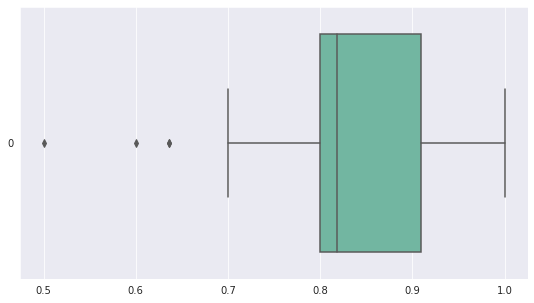

In [ ]:
plt.figure(figsize=(20, 5))
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    plt.subplot(121)
    sns.boxplot(data=old_scores, 
                orient='h',
                palette='Set2')

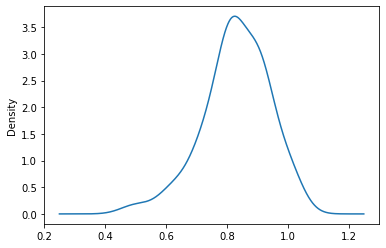

In [ ]:
s = pd.Series(old_scores)
s.plot.kde()

## Selection hyperparameters

In [ ]:
%pylab inline

X_cv = data_gtm_20.drop(columns=['Группа по эфф-ти'])
Y_cv = data_gtm_20['Группа по эфф-ти']

t_stats = []
n_trees = []

for j in tqdm(range(3, 20, 1)):
    current_score = np.array([])
    for i in range(10):
        fold = KFold(n_splits=5, shuffle=True, random_state=i)
        scores_on_this_split = cross_val_score(
            estimator=catboost.CatBoostClassifier(iterations=200,
                                                  auto_class_weights='Balanced',
                                                  metric_period=200,
                                                  depth=j,
                                                  cat_features=cat_features_20), 
            X=X_cv, 
            y=Y_cv,
            cv=fold, 
            scoring='accuracy')
         
        current_score = np.append(current_score, scores_on_this_split)

    t_stat, p_value = ttest_rel(current_score, old_scores)
    t_stats.append(t_stat)
    n_trees.append(j)

plt.plot(n_trees, t_stats)
plt.xlabel('n_estimators')
plt.ylabel('t-statistic')

##Подготовка данных и настройка модели без валидационной и тестовой выборок

In [26]:
# train_df = data_gtm.sample(56)
X_train = data_gtm.drop(columns=['Группа по эффективности'])
Y_train = data_gtm['Группа по эффективности']

train_pool = catboost.Pool(X_train, 
                           label=Y_train, 
                           cat_features=cat_features_20)

# test_df = data_gtm[~data_gtm.index.isin(train_df.index)]
# test_df.drop(columns=['Группа по эффективности'])
# test_pool = catboost.Pool(test_df.drop(columns=['Группа по эффективности']), 
#                            label=test_df['Группа по эффективности'], 
#                            cat_features=cat_features_20)



# print(f'Размер исходной выборки train_df: {train_df.shape} \nРазмер исходной выборки test_df: {test_df.shape}')

In [27]:
clf = catboost.CatBoostClassifier(
      iterations=200, auto_class_weights='Balanced',
      metric_period=100,
      depth=8,
      cat_features=cat_features_20
    ) 

clf.fit(train_pool)

Learning rate set to 0.01346
0:	learn: 0.6844694	total: 10.6ms	remaining: 2.1s
100:	learn: 0.2407223	total: 391ms	remaining: 383ms
199:	learn: 0.1228506	total: 793ms	remaining: 0us


## Проверка качества полученной модели

In [ ]:
#тестовая выборка берется из кросс-валидации
test_metrics = clf.eval_metrics(
    test_pool,
    metrics=['AUC', 'Accuracy', 'Precision', 'Recall', 'F1'],
    ntree_start=99 - 1,
    ntree_end=99,
    eval_period=1,
    thread_count=-1)

test_metrics

{'AUC': [1.0],
 'Accuracy': [1.0],
 'F1': [1.0],
 'Precision': [1.0],
 'Recall': [1.0]}

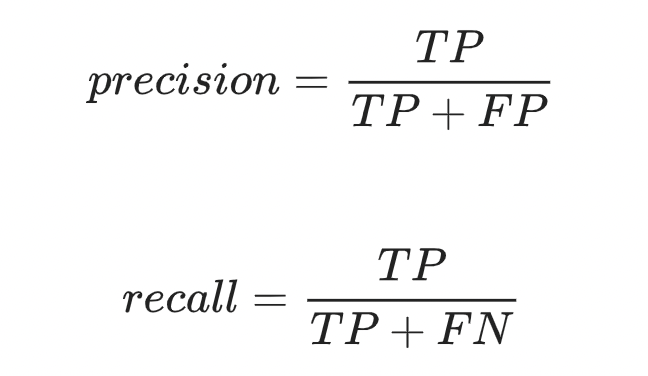

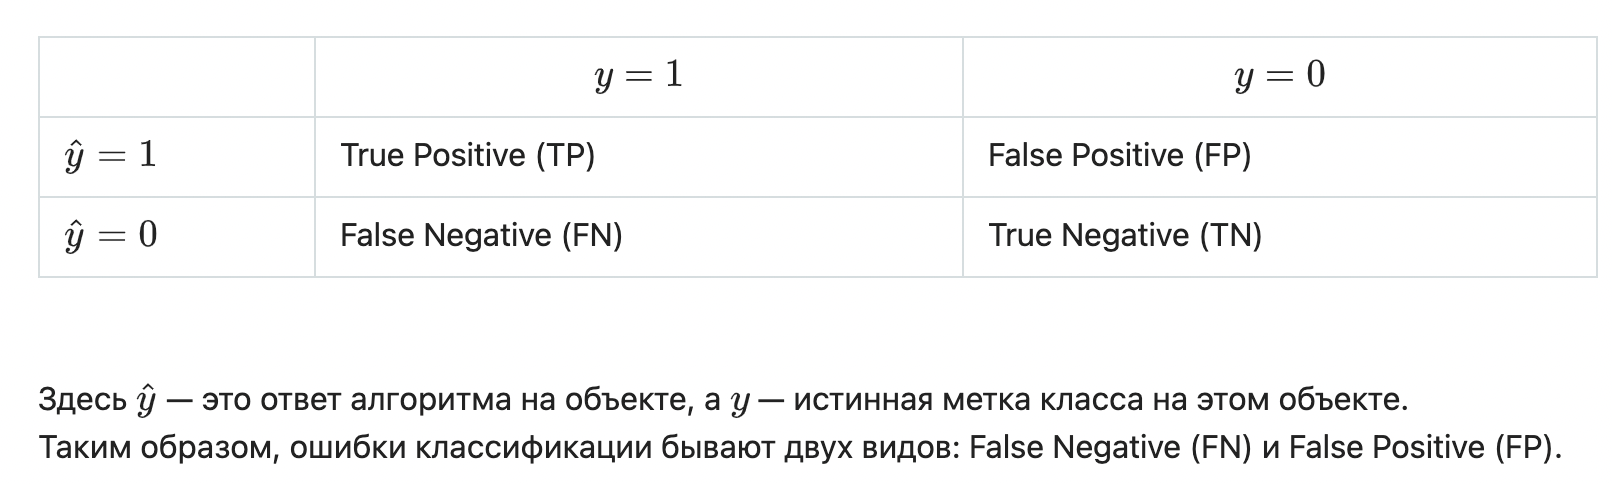

## Прогнозирование вероятности, принадлежать определенному классу

In [44]:
predict_data_gtm = pd.read_excel('/content/drive/MyDrive/Скважины-кандидаты.xlsx', sheet_name='Кандидаты')
predict_data_gtm.head()

,№ скв.,Мест-е,Qж_ф,%воды_руч,ННО,"Vкс_факт, м3","Уд. Vкс, м3/м","V_т.в., м3","Твыд, ч","Nнефт.пр., ед.","h_нефтТР., ед.","Кпзп, мкм2","Кузп, мкм2",S,"Рпл, МПа","Рзаб, МПа",Рплтек/Рнач,Рплтек/Рнас,Рзабтек/Рнас,Рзабтек/Рпл нач,Рзабтек/Рпл тек,N ГРП/КГРП
0,13,Проворовское,10.47,7.45,214,30,3.409091,24.9999,4,8,8.8,0.0312,0.0181,-3.7,13.84,6.83,0.649765,0.728421,0.359474,0.320657,0.493497,0
1,205,Маговское,20.00,3.89,1819,30,5.172414,24.9999,4,7,5.8,0.0060,0.0068,0.5,20.97,5.32,1.061772,1.564925,0.397015,0.269367,0.253696,0


In [45]:
predict = predict_data_gtm.loc[:,['№ скв.','Мест-е']]
predict_data_gtm = predict_data_gtm.drop(columns=['№ скв.','Мест-е'])
print(f'Размер исходной выборки: {predict_data_gtm.shape}')

Размер исходной выборки: (2, 20)


In [46]:
df_predict_proba = clf.predict_proba(predict_data_gtm, 
                                        #ntree_start=99 - 1,
                                        #ntree_end=99,
                                        thread_count=-1)

#predict = pd.DataFrame()
#predict['Фактическая группа'] = test_df['Группа по эффективности']
predict['Неудача'] = [item[0] for item in df_predict_proba]
predict['Успех'] = [item[1] for item in df_predict_proba]

predict

,№ скв.,Мест-е,Неудача,Успех
0,13,Проворовское,0.152156,0.847844
1,205,Маговское,0.265350,0.734650


## Интерпретация признаков

In [ ]:
sorted(
    zip(data_gtm.drop(columns=['Группа по эффективности']).columns, clf.feature_importances_), 
    key=lambda p: p[1], 
    reverse=True)

Интерпретация признаков, внесших вклад с помощью SHAP

In [29]:
explainer = shap.TreeExplainer(clf)#.shap_values(X_train)
shap_values = explainer.shap_values(X_train)
print('Показывает кол-во классов, кол-во строк, кол-во признаков: \n', np.array(explainer.shap_values(X_train)).shape)

Показывает кол-во классов, кол-во строк, кол-во признаков: 
 (59, 20)


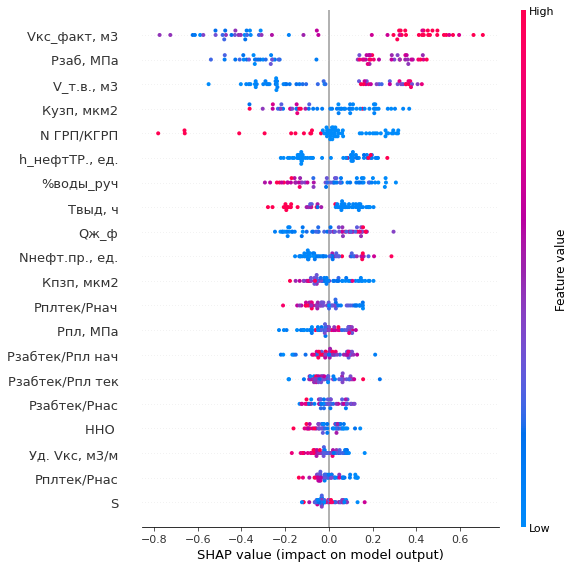

In [30]:
shap.summary_plot(shap_values, X_train, 
                  class_names=clf.classes_
                  )

In [ ]:
shap.summary_plot("Vкс_факт, м3", shap_values[2], X_train)

In [ ]:
shap_info = clf.get_feature_importance(
    data=train_pool, 
    type='ShapValues', 
    verbose=5)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]

shap_values.shape

Processing trees...
100/100 trees processed	passed time: 58us	remaining time: 0us
Processing documents...
55/55 documents processed	passed time: 112ms	remaining time: 0us


(55, 2, 35)

In [ ]:
shap.summary_plot(shap_values, features=X_train)

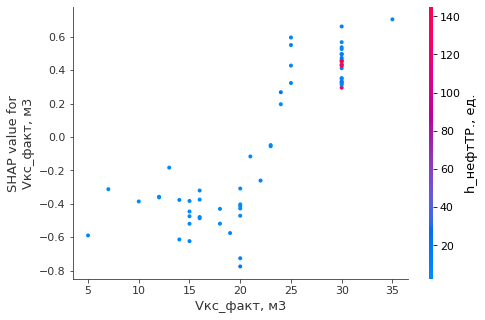

In [ ]:
shap.dependence_plot("Vкс_факт, м3", shap_values, features=X_train)

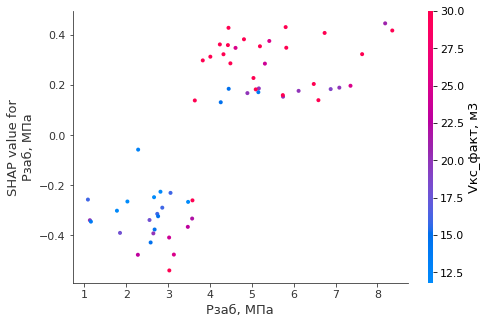

In [ ]:
shap.dependence_plot("Рзаб, МПа", shap_values, features=X_train)